# Can You Predict SSIM from PSNR? Let’s Find Out

The Peak Signal-to-Noise Ratio (PSNR) is a simple metric. It measures the average squared error between two images and turns it into a logarithmic scale. It's fast, cheap and easy to compute

The Structural Similarity Index Measure (SSIM), on the other hand, is more perceptually motivated. It looks at local structure, contrast, and luminance. It operates window by window. It feels more sophisticated and refined.

Because of this, PSNR and SSIM are often treated as fundamentally different metrics.

But are they?
- What if PSNR actually contains more structural information than we usually assume?
- What if SSIM can be predicted, or at least _approxSSIMated_, from PSNR and statistics of the reference image?

In this notebook, we will:
- Revisit the mathematical definitions of PSNR and SSIM
- Visualize how they behave on compression-based distortions
- Walk through the key assumptions behind their relationship
- Translate those assumptions directly into code.

This is not a formal paper (I already wrote one of those), this is a guided exploration.

Let's start with the basics.

# A Tale of Two Qualities

We begin with a single reference image. In this notebook, we will use kodim23 from the Kodak image dataset.

Now we compress it twice:
- Once at JPEG quality 50
- Once at JPEG quality 25

If you look closesly, you can start to see the differences.

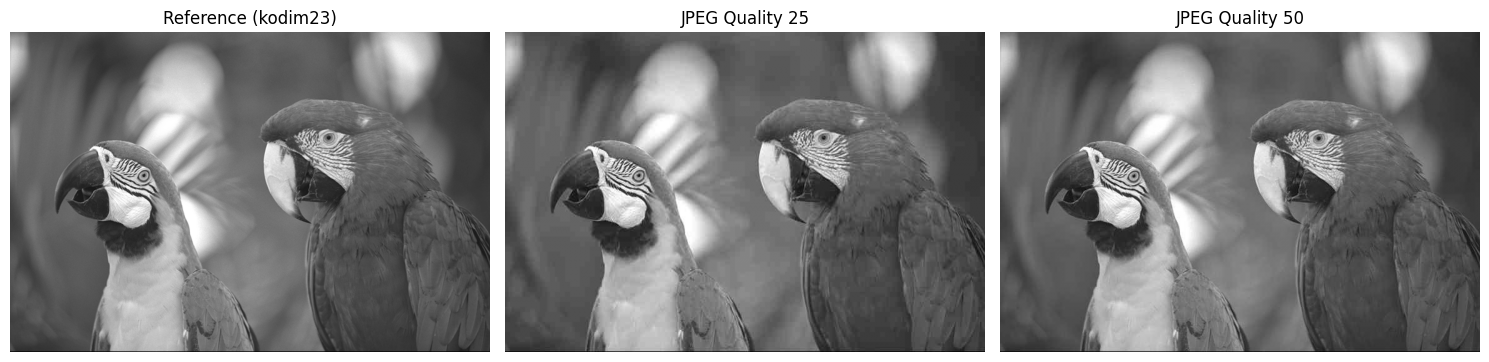

In [13]:
import os
import urllib.request
from pathlib import Path
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt

def fetch_kodak(index=23, cache_dir="data"):
    """
    Download a Kodak image (1-24) if not already cached.
    Returns a numpy array (grayscale).
    """
    assert 1 <= index <= 24, "Kodak index must be between 1 and 24"
    
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    filename = f"kodim{index:02d}.png"
    filepath = cache_dir / filename
    
    if not filepath.exists():
        url = f"http://r0k.us/graphics/kodak/kodak/{filename}"
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    
    img = Image.open(filepath).convert("L")
    return np.array(img, dtype=np.uint8)

def jpeg_compress(img, quality=75):
    buffer = io.BytesIO()
    Image.fromarray(img, 'L').save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    return Image.open(buffer)

# Example usage
ref = fetch_kodak(23)
q25 = np.array(jpeg_compress(ref, quality=25), dtype=np.uint8)
q50 = np.array(jpeg_compress(ref, quality=50), dtype=np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ref, cmap="gray")
axes[0].set_title("Reference (kodim23)")
axes[0].axis("off")

axes[1].imshow(q25, cmap="gray")
axes[1].set_title("JPEG Quality 25")
axes[1].axis("off")

axes[2].imshow(q50, cmap="gray")
axes[2].set_title("JPEG Quality 50")
axes[2].axis("off")

plt.tight_layout()
plt.show()


But here is something important for later:
these images are not random or unrelated. They are two compressed versions of the same underlying signal. There is structure connecting them.

We will come back to that idea.

For now, let’s ask a simpler question:

How can we measure the “distance” between these images?

There are many ways to measure error: absolute error, squared error, perceptual metrics... but in compression, one metric dominates: the Mean Squared Error (MSE).